In [1]:
import os
import pickle

from typing import Any, Dict, Tuple
import numpy as np
import pandas as pd
import json
from ast import literal_eval as make_tuple

from utils.error_metrics import MulticlassErrorMetrics, DatasetCategory

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold


def get_dataset_with_dependend_variabels(
    df_set: pd.DataFrame, df_dependent: pd.DataFrame
) -> pd.DataFrame:
    df = df_set[
        ["Date", "Area", "mapped_hazard_forecast", "mapped_hazard_observed"]
    ].copy()
    df["Date"] = pd.to_datetime(df["Date"]).dt.date
    df_dependent["Date"] = pd.to_datetime(df_dependent["Date"]).dt.date
    df = df.merge(df_dependent, on=["Date", "Area"])
    return df


def xy_split(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return (
        df.drop(
            columns=["Date", "Area", "mapped_hazard_forecast", "mapped_hazard_observed"]
        ),
        df["mapped_hazard_forecast"],
    )


def fit_and_compute_errors(
    errs: MulticlassErrorMetrics,
    independent_variables_and_sets: Tuple[str, Dict[DatasetCategory, pd.DataFrame]],
    model_name_and_pipeline: Tuple[str, Pipeline],
):
    independent_variables = independent_variables_and_sets[0]
    sets = independent_variables_and_sets[1]
    model_name = model_name_and_pipeline[0]
    pipe = model_name_and_pipeline[1]

    training_set = sets[DatasetCategory.TRAINING]
    x, y = xy_split(training_set)
    pipe.fit(x, y)

    for ds_type, ds in sets.items():
        x, _ = xy_split(ds)
        y_pred = pipe.predict(x)
        errs.compute_errors(model_name, independent_variables, ds_type, y_pred)


def params_to_file(file_name: str, params: Dict[str, Any]) -> None:
    with open(f"../data/aux/params/{file_name.replace(".*","")}.json", "w") as f:
        json.dump(params, f)


def params_from_file(file_name: str) -> Dict[str, Any]:
    file_name = f"../data/aux/params/{file_name.replace(".*","")}.json"
    if not os.path.exists(file_name):
        raise FileNotFoundError(f"The file {file_name} does not exist.")
    with open(file_name, "r") as f:
        d = json.load(f)
        hidden_layer_sizes = d.get("hidden_layer_sizes", None)
        if not hidden_layer_sizes is None:
            d["hidden_layer_sizes"] = make_tuple(hidden_layer_sizes)
        return d

In [2]:
df_train = pd.read_csv("../data/processed/SAIS_train.csv", index_col=0)
df_test = pd.read_csv("../data/processed/SAIS_test.csv", index_col=0)

df_tab = pd.read_csv("../data/processed/SAIS_tabularised.csv", index_col=0)

df_train_tab = df_tab.loc[df_train.index]
df_test_tab = df_tab.loc[df_test.index]

df_weather_data_daily_tab = pd.read_csv(
    "../data/proprietary/weather/visual_crossing/weather_observed_days_tabularised.csv"
)
df_weather_data_48h_then_daily_tab = pd.read_csv(
    "../data/proprietary/weather/visual_crossing/weather_observed_tabularised_48_hours_then_days.csv"
)

snowprofiles = (
    "snow profiles",
    {
        DatasetCategory.TRAINING: df_train,
        DatasetCategory.TEST: df_test,
    },
)

snowprofiles_whole_season = (
    "snow profiles across season",
    {
        DatasetCategory.TRAINING: df_train_tab,
        DatasetCategory.TEST: df_test_tab,
    },
)

weather_daily_whole_season = (
    "weather daily data across season",
    {
        DatasetCategory.TRAINING: get_dataset_with_dependend_variabels(
            df_train, df_weather_data_daily_tab
        ),
        DatasetCategory.TEST: get_dataset_with_dependend_variabels(
            df_test, df_weather_data_daily_tab
        ),
    },
)

weather_48h_then_daily_season = (
    "weather 48h hourly then daily data across season",
    {
        DatasetCategory.TRAINING: get_dataset_with_dependend_variabels(
            df_train, df_weather_data_48h_then_daily_tab
        ),
        DatasetCategory.TEST: get_dataset_with_dependend_variabels(
            df_test, df_weather_data_48h_then_daily_tab
        ),
    },
)

errs_summary = MulticlassErrorMetrics(
    dataset_name="sais",
    classes=sorted(df_train["mapped_hazard_forecast"].unique()),
    y_true_train=df_train["mapped_hazard_forecast"],
    y_true_dev=None,
    y_true_test=df_test["mapped_hazard_forecast"],
)


In [3]:
most_frequent_value = df_train["mapped_hazard_forecast"].value_counts().index[0]

run = lambda model, data: fit_and_compute_errors(
    errs=errs_summary,
    independent_variables_and_sets=data,
    model_name_and_pipeline=model,
)

model_name_const = "const "
errs_summary.compute_errors_all_sets(
    model_name_const,
    None,
    most_frequent_value,
    None,
    most_frequent_value,
)
model_name_obs = "obs.  "
errs_summary.compute_errors_all_sets(
    model_name_obs,
    None,
    df_train["mapped_hazard_observed"],
    None,
    df_test["mapped_hazard_observed"],
)

scaler = StandardScaler()

softmax_snow = (
    "SM(S)",
    Pipeline(
        [
            ("scaler", scaler),
            ("model", LogisticRegression(random_state=1)),
        ]
    ),
)

softmax = (
    "SM    ",
    Pipeline(
        [
            ("scaler", scaler),
            ("model", LogisticRegression(random_state=1)),
        ]
    ),
)

softmax_tuned = (
    "SM(T)",
    Pipeline(
        [
            ("scaler", scaler),
            ("model", LogisticRegression(random_state=1).set_params(
                    **params_from_file("softmax_tuned"))),
        ]
    ),
)

random_forest = (
    "RF    ",
    Pipeline(
        [
            ("scaler", scaler),
            ("model", RandomForestClassifier(random_state=1)),
        ]
    ),
)

random_forest_tuned = (
    "RF(T) ",
    Pipeline(
        [
            ("scaler", scaler),
            (
                "model",
                RandomForestClassifier(random_state=1).set_params(
                    **params_from_file("random_forest_tuned")
                ),
            ),
        ]
    ),
)
random_forest_tuned[1]["model"].set_params(**{"warm_start": False})

mlp = (
    "MLP   ",
    Pipeline(
        [
            ("scaler", scaler),
            ("model", MLPClassifier(random_state=1, early_stopping=True)),
        ]
    ),
)


mlp_tuned = (
    "MLP(T)",
    Pipeline(
        [
            ("scaler", scaler),
            (
                "model",
                MLPClassifier(random_state=1, early_stopping=True).set_params(
                    **params_from_file("mlp_tuned")
                ),
            ),
        ]
    ),
)

In [4]:
rerun = False

#long-running
if rerun:
    run(softmax_snow, snowprofiles)

    # run(softmax, snowprofiles_whole_season)

    # run(softmax, weather_daily_whole_season)

    run(softmax, weather_48h_then_daily_season)

    run(softmax_tuned, weather_48h_then_daily_season)

    run(random_forest, weather_48h_then_daily_season)

    run(mlp, weather_48h_then_daily_season)

    run(random_forest_tuned, weather_48h_then_daily_season)

    run(mlp_tuned, weather_48h_then_daily_season)
    with open("../data/aux/errs_summary.pkl", "wb") as f:
        pickle.dump(errs_summary, f)
else:
    with open("../data/aux/errs_summary.pkl", 'rb') as f:
        errs_summary = pickle.load(f)

In [5]:
errs_summary.save_assets(table_transpose=True, table_model_name_only=True, table_float_format = "{:0.2f}", table_caption_additional=". \\\\ SM = softmax, RF = Random forest, MLP = Multi-layer perceptron, S = snow profiles, T = tuned")

errs_summary.get_error_table_for_set(DatasetCategory.TEST)

,MSE,average error,accuracy,precision:,1,2,3,4,,prec. (macro),...,,recall (macro),$F_1$:,1,2,3,4,,$F_1$ (macro),confusion matrix
"const , None",1.62786,-0.893747,0.328419,,0.0,0.0,0.33,0.0,,0.082105,...,,0.25,,0.0,0.0,0.49,0.0,,0.123613,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [..."
"obs. , None",0.300458,0.146924,0.758516,,0.76,0.69,0.84,0.67,,0.738307,...,,0.686051,,0.84,0.67,0.78,0.52,,0.702249,"[[0.9266347687400319, 0.0733652312599681, 0.0,..."
"SM(S), snow profiles",0.526182,0.071683,0.608541,,0.68,0.48,0.62,0.36,,0.533047,...,,0.486607,,0.73,0.4,0.68,0.09,,0.476224,"[[0.7974481658692185, 0.16108452950558214, 0.0..."
"SM , weather 48h hourly then daily data across season",0.554143,0.009151,0.603965,,0.71,0.49,0.63,0.45,,0.569569,...,,0.565966,,0.72,0.49,0.63,0.44,,0.567711,"[[0.7192982456140351, 0.21371610845295055, 0.0..."
"SM(T), weather 48h hourly then daily data across season",0.584647,-0.075241,0.611591,,0.74,0.52,0.66,0.32,,0.559963,...,,0.614617,,0.73,0.51,0.63,0.43,,0.574263,"[[0.7256778309409888, 0.19617224880382775, 0.0..."
"RF , weather 48h hourly then daily data across season",0.365531,0.038129,0.699542,,0.79,0.62,0.68,0.83,,0.729025,...,,0.58229,,0.81,0.58,0.73,0.27,,0.596466,"[[0.8245614035087719, 0.1371610845295056, 0.03..."
"MLP , weather 48h hourly then daily data across season",0.493137,-0.002034,0.652771,,0.72,0.59,0.63,0.61,,0.638481,...,,0.584689,,0.75,0.5,0.7,0.44,,0.597647,"[[0.7830940988835726, 0.13556618819776714, 0.0..."
"RF(T) , weather 48h hourly then daily data across season",0.439756,0.027961,0.674631,,0.76,0.61,0.64,0.86,,0.715913,...,,0.569101,,0.78,0.55,0.7,0.31,,0.586487,"[[0.8054226475279107, 0.12280701754385964, 0.0..."
"MLP(T), weather 48h hourly then daily data across season",0.408236,0.031012,0.67514,,0.77,0.56,0.7,0.6,,0.656521,...,,0.626611,,0.77,0.57,0.7,0.51,,0.639042,"[[0.7814992025518341, 0.17862838915470494, 0.0..."


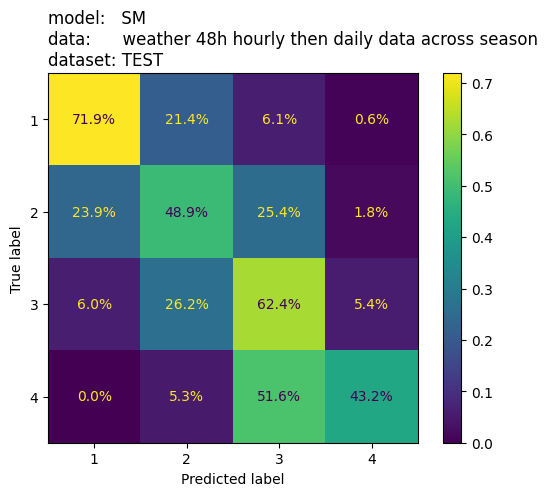

In [6]:
errs_summary.show_confusion_matrix(
    model_name=softmax[0],
    independent_variables=weather_48h_then_daily_season[0],
    set_cat=DatasetCategory.TEST,
)

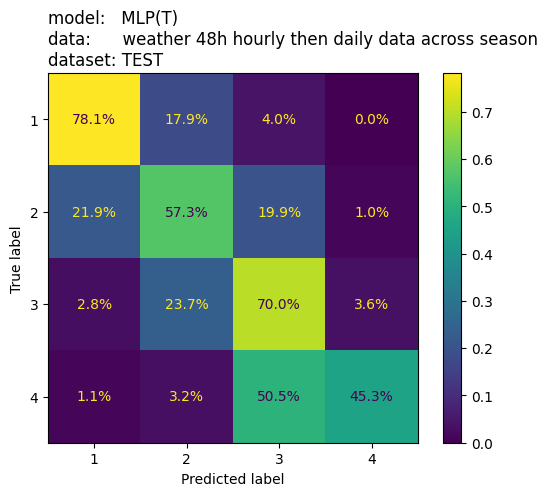

In [7]:
errs_summary.show_confusion_matrix(
    model_name=mlp_tuned[0],
    independent_variables=weather_48h_then_daily_season[0],
    set_cat=DatasetCategory.TEST,
)

## Hyperparameter tuning

In [8]:
rerun_softmax = False
rerun_random_forest = False
rerun_mlp = False

# long running
if rerun_softmax:
    grid = {
        "model__warm_start": [True],
        "model__penalty": ["l1", "l2", "elasticnet", None],
        "model__tol": [1e-2, 1e-4, 1e-6],
        "model__C": [1e-3, 1e-2, 1e-1, 1],
        "model__fit_intercept": [False, True],
        "model__solver": ["lbfgs", "newton-cg", "sag", "saga"],
        "model__class_weight": [
            "balanced",
            "balanced_subsample",
            {1: 0.1, 2: 0.3, 3: 0.1, 4: 0.5},
            {1: 0.01, 2: 0.45, 3: 0.09, 4: 0.45},
        ],
    }
    random_search_softmax = RandomizedSearchCV(
        estimator=softmax[1],
        n_jobs=-1,
        cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1),
        param_distributions=grid,
        scoring="f1_macro",
        n_iter=20,
        verbose=1
    )

    run(
        ("Softmax (tuned)", random_search_softmax),
        weather_48h_then_daily_season,
    )
    params_to_file(
        "softmax_tuned", random_search_softmax.best_estimator_["model"].get_params()
    )

# long running
if rerun_random_forest:
    # Followed approach in: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    grid = {
        "model__n_estimators": [100,200],
        "model__criterion": ["gini", "entropy", "log_loss"],
        "model__max_features": [None, "sqrt", "log2"],
        "model__max_depth": [None, 10, 50],
        "model__class_weight": [
            "balanced",
            {1: 0.01, 2: 0.45, 3: 0.09, 4: 0.45},
        ],
    }
    random_search_random_forrest = RandomizedSearchCV(
        estimator=random_forest[1],
        n_jobs=-1,
        cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1),
        param_distributions=grid,
        scoring="f1_macro",
        n_iter=20,
        verbose=1
    )

    run(
        ("Random forrest (tuned)", random_search_random_forrest),
        weather_48h_then_daily_season,
    )
    params_to_file(
        "random_forest_tuned",
        random_search_random_forrest.best_estimator_["model"].get_params(),
    )


# long running
if rerun_mlp:

    grid = {
        "model__hidden_layer_sizes": [
            (100,),
            (1000,),
            (100, 300, 100),
            (10, 30, 10),
            (20,),
        ],
        "model__activation": ["relu", "logistic", "tanh"],
        "model__solver": ["sgd", "adam"],
        "model__alpha": [0.0001, 0.001, 0.01],
        "model__learning_rate": ["constant", "invscaling", "adaptive"],
        "model__momentum": [0.1, 0.5, 0.9],
    }

    random_search_mlp = RandomizedSearchCV(
        estimator=mlp[1],
        n_jobs=-1,
        cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1),
        param_distributions=grid,
        scoring="f1_macro",
        n_iter=20,
        verbose=1,
    )

    run(("MLP (tuned)", random_search_mlp), weather_48h_then_daily_season)
    params_to_file("mlp_tuned", random_search_mlp.best_estimator_["model"].get_params())

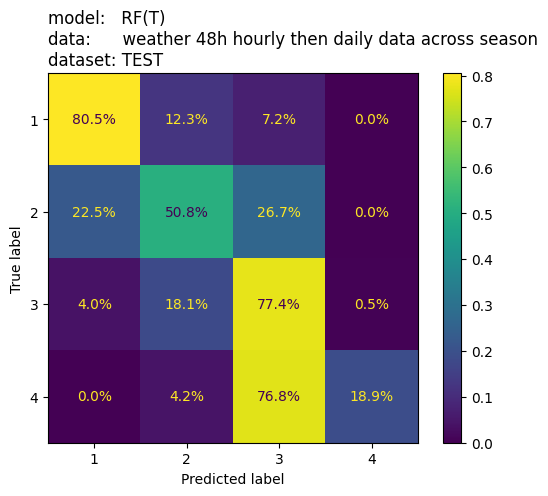

In [9]:
errs_summary.show_confusion_matrix(
    model_name=random_forest_tuned[0],
    independent_variables=weather_48h_then_daily_season[0],
    set_cat=DatasetCategory.TEST,
)